## Reproduce Published results with Starfish

The MERFISH.zip file needed to run this notebook is downloadable [here](https://drive.google.com/open?id=1YQ3QcOBIoL6Yz3SStC0vigbVaH0C7DkW)

This notebook walks through a workflow that reproduces a MERFISH result for one field of view using the starfish package. It assumes you have unzipped MERFISH.zip in the same directory. Thus, you should see: 

```
MERFISH/
Starfish MERFISH Pipeline - U2O2 Cell Culture - 1 FOV.ipynb
```

## Load tiff stack and visualize one field of view

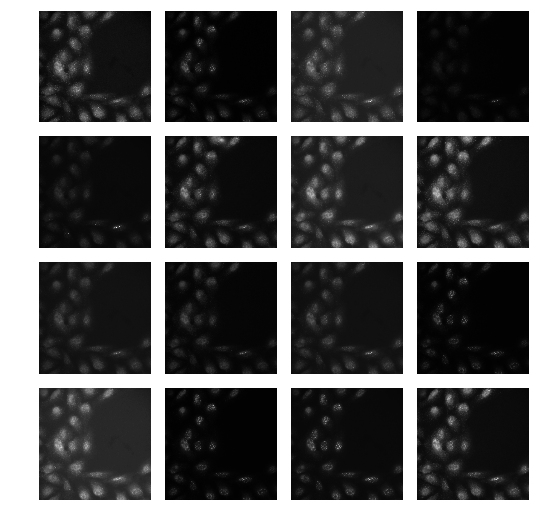

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from showit import image, tile
import time
import pprint

%matplotlib inline

from starfish.io import Stack


# load in current directory so we can also grab the benchmark results later
s = Stack()
s.read('MERFISH/fov_001/org.json')

# produce a 1d array from the image tensor
tile(s.squeeze());  

## Show input file format that specifies how the tiff stack is organized

The stack contains multiple images corresponding to the channel and hybridization round. MERFISH builds a 16 bit barcode from 8 hybridization rounds, each of which measures two channels that correspond to contiguous (but not necessarily consistently ordered) bits of the barcode. 

The MERFISH computational pipeline also constructs a "scale" size factor that corrects for intensity differences across the different bits of the barcode

The stacks in this example are pre-registered using fiduciary beads. 

In [2]:
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(s.org)

{ 'aux': [{'file': 'dapi.tiff', 'format': 'TIFF', 'type': 'dapi'}],
  'data': [ {'bit': 0, 'ch': 0, 'file': 'H_0_C_0.tiff', 'hyb': 0},
            {'bit': 1, 'ch': 1, 'file': 'H_0_C_1.tiff', 'hyb': 0},
            {'bit': 2, 'ch': 1, 'file': 'H_1_C_1.tiff', 'hyb': 1},
            {'bit': 3, 'ch': 0, 'file': 'H_1_C_0.tiff', 'hyb': 1},
            {'bit': 4, 'ch': 0, 'file': 'H_2_C_0.tiff', 'hyb': 2},
            {'bit': 5, 'ch': 1, 'file': 'H_2_C_1.tiff', 'hyb': 2},
            {'bit': 6, 'ch': 0, 'file': 'H_3_C_0.tiff', 'hyb': 3},
            {'bit': 7, 'ch': 1, 'file': 'H_3_C_1.tiff', 'hyb': 3},
            {'bit': 8, 'ch': 1, 'file': 'H_4_C_1.tiff', 'hyb': 4},
            {'bit': 9, 'ch': 0, 'file': 'H_4_C_0.tiff', 'hyb': 4},
            {'bit': 10, 'ch': 0, 'file': 'H_5_C_0.tiff', 'hyb': 5},
            {'bit': 11, 'ch': 1, 'file': 'H_5_C_1.tiff', 'hyb': 5},
            {'bit': 12, 'ch': 0, 'file': 'H_6_C_0.tiff', 'hyb': 6},
            {'bit': 13, 'ch': 1, 'file': 'H_6_C_1.tiff', '

## Visualize codebook

The MERFISH codebook maps each barcode to a gene (or blank) feature. The codes in the MERFISH codebook are constructed from a 4-hamming error correcting code with exactly 4 "on" bits per barcode

In [3]:
codebook = pd.read_csv('MERFISH/codebook.csv', dtype={'barcode': object})
codebook.head(20)

,barcode,gene
0,0011100000001000,Blank-1
1,1001100100000000,Blank-10
2,0011000100100000,Blank-2
3,0011010001000000,Blank-3
4,0010010000001100,Blank-4
5,0010001000101000,Blank-5
6,1000101000001000,Blank-6
7,0101100000000010,Blank-7
8,0001000001001100,Blank-8
9,0000100100101000,Blank-9


## Filter and scale raw data before decoding

In [4]:
from starfish.filters import gaussian_high_pass, gaussian_low_pass, richardson_lucy_deconv
from starfish.viz import tile_lims

Begin filtering with a high pass filter to remove background

In [5]:
sigma = 3
# bit_map_flag orders the linearized lit by bit
stack_high_pass = [gaussian_high_pass(im, sigma) for im in s.squeeze(bit_map_flag=True)]

The below algorithm deconvolves out the point spread function introduced by the microcope and is specifically designed for this use case. The number of iterations is an important parameter that needs careful optimization. 

In [6]:
num_iter=14
sigma = 2
kernel_size = int(2*np.ceil(2*sigma)+1)
gpar = (kernel_size, sigma)
stack_deconv = [richardson_lucy_deconv(im, num_iter, gpar=gpar) for im in stack_high_pass]

Recall that the image is pre-registered, as stated above. Despite this, there are noise functions that cause individual RNA to move across hybridization rounds. As a result, the same RNA must be mapped across hybridization rounds. A trivial way to accomplish this is to blur the spot across a large enough area that you expand it beyond the jitter radius. This is what is done below. 

A local search could also solve this. 

In [7]:
sigma = 1
stack_blurred = [gaussian_low_pass(im, sigma) for im in stack_deconv]

Use MERFISH-calculated size factors to scale the channels across the hybridization rounds and visualize the resulting filtered and scaled images

In [8]:
sc = s.org['metadata']['scale']
sc_df = pd.DataFrame([(int(k), v) for k,v in sc.items()], columns = ['bit', 'scale'])
mp = pd.merge(s.squeeze_map, sc_df, on='bit', how='left')
scale_dict = dict(zip(mp.ind.values, mp.scale.values))

for k, v in scale_dict.items():
    stack_blurred[k] = stack_blurred[k]/v
    
s.set_stack(s.un_squeeze(stack_blurred))

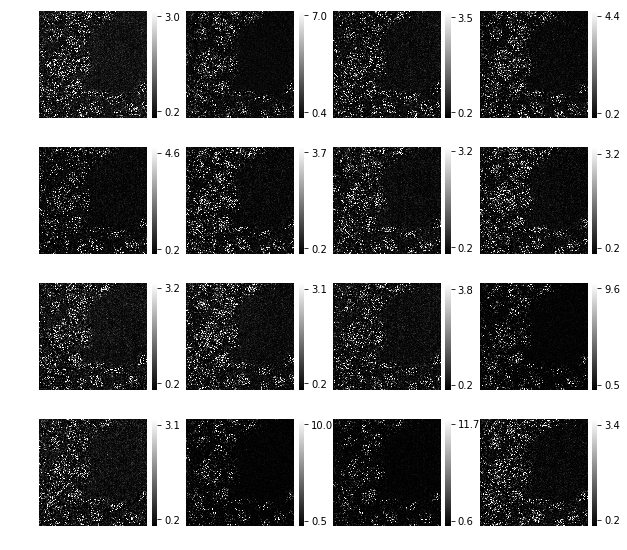

In [9]:
tile_lims(stack_blurred, 2, size=10);

## Use spot-detector to create 'encoder' table  for standardized input  to decoder

Each pipeline exposes a spot detector, and this spot detector translates the filtered image into an encoded table by detecting spots. 

The table contains the spot_id, the corresponding intensity (val) and the channel (ch), hybridization round (hyb), and bit of each spot. 

The Encoder table is the hypothesized standardized file format for the output of a spot detector, and is the first format that is not an image stack.

In [10]:
from starfish.spots.pixel import PixelSpotDetector

# create 'encoder table' standard (tidy) file format. each pixel is a 'spot'
p = PixelSpotDetector(s)
encoded = p.detect(bit_map_flag=True)
pd.concat([encoded.head(5), encoded.tail(5)])

,spot_id,ind,val,ch,hyb,bit
0,0,0,0.009539,0,0,0
1,1,0,0.038157,0,0,0
2,2,0,0.066775,0,0,0
3,3,0,0.066775,0,0,0
4,4,0,0.066775,0,0,0
67108859,4194299,15,0.134463,1,7,14
67108860,4194300,15,0.089642,1,7,14
67108861,4194301,15,0.044821,1,7,14
67108862,4194302,15,0.022410,1,7,14
67108863,4194303,15,0.000000,1,7,14


## Decode

Each assay type also exposes a decoder. A decoder translates each spot (spot_id) in the encoded table into a gene (that matches a barcode) and associates this information with the stored position. The goal is to decode and output a quality score that describes the confidence in the decoding. 

There are hard and soft decodings -- hard decoding is just looking for the max value in the code book. Soft decoding, by contrast, finds the closest code by distance (in intensity). Because different assays each have their own intensities and error modes, we leave decoders as user-defined functions. 

For MERFISH, there are several parameters which are important to determining the result of the decoding method: 

### Distance threshold
In MERFISH, each pixel is a 16d vector that you want to map onto a barcode via a euclidean distance function. Because of the way the hamming-4 codebook was designed, any code within a distance of 2 of a designed code should correspond to a hybridization event to an mRNA. The below value (0.5176) maps to this value via the _____ function

### Magnitude threshold
This is a signal floor for decoding. Spots with intensity below this floor are not considered for decoding. 

### Area threshold
This is the minimum size of a spot. This is set based on the microscope and resolution. 

Finally, the crop_size parameter is a function of the microscope, and crops the image by a number of pixels large enough to eliminate parts of the image that suffer from boundary effects. Here this value is 40, and that is set based upon the algorithms, microscope, and field of view overlap. 

Given these three thresholds, for each spot, the decoder picks the closest code (minimum distance) that satisfies each of the above thresholds, where the distance is calculated between the code and a normalized intensity vector. 

In [11]:
from starfish.decoders.merfish import MerfishDecoder

decoder = MerfishDecoder(codebook)

decoded = decoder._decode(encoded,
                    img_size=(2048, 2048),
                    distance_threshold=0.5176,
                    magnitude_threshold=1,
                    area_threshold=2,
                    crop_size=40
                   )

res = decoded.result  # this should be consistent across assays; 
# this one doesn't have a quality, but it should eventually converge to a shared type
res.head()

,area,barcode,x,y,spot_id,gene
0,2,1000110010000000,40.0,68.5,0,FASN
1,4,1100000010100000,40.5,73.5,1,FZD4
2,2,0111000000010000,40.0,161.5,2,POLQ
3,4,0000010011000010,41.0,304.5,3,UBR5
4,2,0100000000010101,40.0,319.5,4,MALAT1


In the above method, the private method of the decoder is used, which exposes additional metadata about the spots. 

In [12]:
print('Additional metadata:')
[f for f in dir(decoded) if not f.startswith('_')]

Additional metadata:


['count', 'decoded_img', 'index', 'label_img', 'result', 'spot_props']

## Compare to results from paper 

The below plot aggregates gene copy number across single cells in the field of view and compares the results to the published intensities in the MERFISH paper. 

To make this match perfectly, run deconvolution 15 times instead of 14. As presented below, STARFISH displays a lower detection rate.  

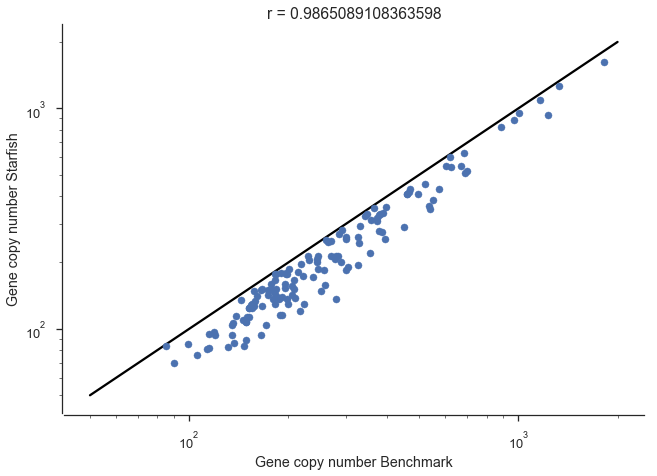

In [13]:
import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')

bench = pd.read_csv(os.path.join('MERFISH', 'benchmark_results.csv'), dtype = {'barcode':object})
x_cnts = res.groupby('gene').count()['area']
y_cnts = bench.groupby('gene').count()['area']
tmp = pd.concat([x_cnts, y_cnts], axis=1, join='inner').values
r = np.corrcoef(tmp[:,1], tmp[:,0])[0,1]

x = np.linspace(50, 2000)
plt.scatter(tmp[:,1],tmp[:,0], 50,zorder=2)
plt.plot(x,x,'-k',zorder=1)

plt.xlabel('Gene copy number Benchmark')
plt.ylabel('Gene copy number Starfish')
plt.xscale('log')
plt.yscale('log')
plt.title('r = {}'.format(r))

sns.despine(offset=2)

## Visualize results

This image applies a pseudo-color to each gene channel to visualize the position and size of all called spots in the test image

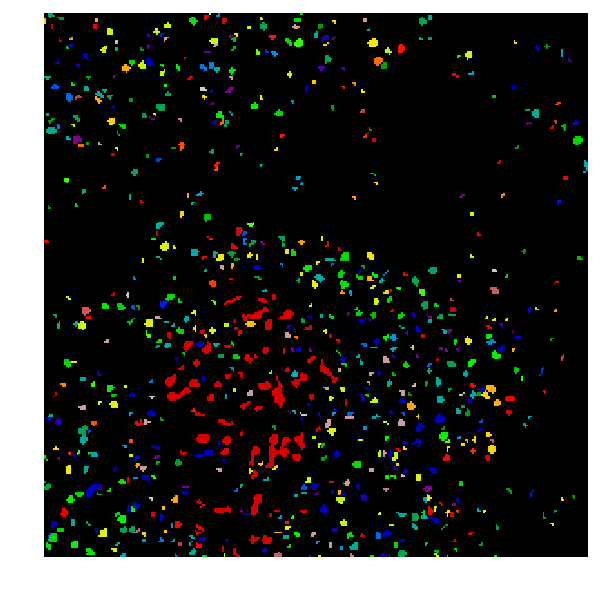

In [14]:
props = decoded.spot_props
area_lookup = lambda x: 0 if x == 0 else props[x-1].area
vfunc = np.vectorize(area_lookup)
mask = vfunc(decoded.label_img)
image((decoded.decoded_img*(mask > 2))[200:500,200:500], cmap = 'nipy_spectral', size=10)